In [5]:
import sys 
import os 

nb_dir = os.getcwd()
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from plotlib.loaders import *
from plotlib.plotters import *

from phdconf import config 
from phdconf.config import * 

%matplotlib inline

In [2]:
display_names = ['AUS']
index_names = ['flattened'] #, 'sigir']
qrel_paths = [config.AUS_QREL_PATH]
rel_levels = ['1', '1']

base_dir = os.path.join(os.environ["HOME"], 'phd-generated')

start = 300
end = 3000
increment = 50

topics = 'case-topics'

def load(index_names, qrel_paths, results_path, run_format, rel_levels, _1s, _1e, _1i, _2s, _2e, _2i, per_query=False, filtered=None):
    dfs = []
    iterator = np.arange(_1s, _1e+_1i, _1i)
    # deal with shitty float overflow on np.arange 
    if iterator[-1] > end: 
        iterator = iterator[:-1]
    for i, ind in enumerate(index_names):
        temp = []
        for j in np.arange(_2s, _2e+_2s, _2i):
            tmp = []
            for l in iterator:
                tmp.append(to_trec_df(qrel_paths[i], os.path.join(results_path, run_format.format(ind, j, l)), rel_levels[i], per_query, filtered))
            temp.append(tmp)
        dfs.append(temp)
    
    return dfs 

# weight_dfs = load_1d_dfs(index_names, qrel_paths, os.path.join(BASE_DIR, PARA_DIR, 'dirichlet_prior'), base_run+'top-{0}-paras-unigram_dir_mu_{1:.2f}-{2:.2f}-rerank.run', rel_levels, start, end, increment)


In [3]:
weight_dfs = load(['case-topics'], [config.AUS_QREL_PATH], os.path.join(base_dir, 'dirichlet_prior') , '{0}-top-{1}-paras-rerank-dir-mu-{2:.2f}.run', rel_levels, start, end, increment, 1, 10, 1)

In [4]:
base_res = load_1d_dfs(['filtered-phrasestop'], qrel_paths, os.path.join(base_dir, 'preprocessing', 'dirichlet_prior'), 'case-topics-{0}-unigram_dir_mu_{1:.2f}.run', rel_levels, 1050, 1050, 1)[0][0]
base_qry = load_1d_dfs(['filtered-phrasestop'], qrel_paths, os.path.join(base_dir, 'preprocessing', 'dirichlet_prior'), 'case-topics-{0}-unigram_dir_mu_{1:.2f}.run', rel_levels, 1050, 1050, 1, per_query=True)[0][0]

tt_folds = read_folds('ausnl-folds.txt')

In [32]:
def plot_rerank_sum_para(dfs, base_res, metric_names,  _1s, _1e, _1i, _2s, _2e, _2i):
    # r = int((len(metric_names))/2)
    # c = r
    # print(r, c)    
    r = 1
    c = 1
    fig, axs = plt.subplots(r, c, subplot_kw=dict(projection='3d'))
    fig.set_size_inches(16, 8)

    
    num_x = len(dfs[0])
    num_y = len(dfs)
    print(num_x, num_y)
    x = np.array([[i]*num_x for i in np.arange(_2s, _2i+_2e, _2i)])
    y = np.array([list(np.arange(_1s, _1i+_1e, _1i))] * num_y)

    cnt = 0 
    row = 0
    for j in metric_names:
        axs.zaxis.set_rotate_label(False)
        axs.set_zlabel(metric_names[j], fontsize=30, rotation=90,labelpad=33)
        axs.set_xlabel('Passages', fontsize=30, rotation=90,labelpad=20)
        axs.set_ylabel('$\mu$', fontsize=30, rotation=90,labelpad=20)
        axs.tick_params(labelsize=20)
        axs.tick_params(axis='z', pad=15)
        
        if j == 'unjudged@20':
            z = np.array([[k[j] for i, k in enumerate(d)] for d in dfs])
        else:
            z = np.array([[k[j]-base_res[j] for i, k in enumerate(d)] for d in dfs])
        print(len(x), len(x[0]), len(y), len(y[0]), len(z), len(z[0]))

        axs.plot_surface(x, y, z, cmap=cm.gray)

        cnt += 1 
        
    # if len(metric_names) % 2 != 0: 
    #     fig.delaxes(axs[row, -1])
            
    fig.tight_layout()
    return fig

fig1 = plot_rerank_sum_para(weight_dfs[0], base_res, {'rbp@0.80': 'RBP'}, start, end, increment, 1, 10, 1)
fig1.savefig('figures/para-sum-3d.pdf')

55 10
10 55 10 55 10 55


<Figure size 1152x576 with 1 Axes>

In [33]:
def select_1d_max_stat_sig(display_names, dfs, start, increment, name, base_qry, base_df, base_val, path, metrics=None):
    measure_max = {}
    for i in range(len(display_names)):
        for j in range(len(dfs[i])):
            for m in dfs[i][j].index:
                if m not in metrics: 
                    continue 
                val = dfs[i][j][m]
                if (display_names[i], metrics[m]) not in measure_max: 
                    measure_max[(display_names[i], metrics[m])] = {'-': val, name: '{0:.2f}'.format(j*increment+start)}
                else: 
                    if measure_max[(display_names[i], metrics[m])]['-'] < val:
                        measure_max[(display_names[i], metrics[m])] = {'-': val, name: '{0:.2f}'.format(j*increment+start)}
    
    back_metric = {v: k for k, v in metrics.items()}
    for k, v in measure_max.items():
        if k[1] == 'Unjudged@20':
            continue
        _l = float(v[name])
        if _l == 0.00:
            v['-'] = '{0:.4f}'.format(v['-'])
        else:
            comp = load_dfs(config.AUS_QREL_PATH, config.AUS_REL_LEVEL, '', [path.format(k[0], float(v[name]))], per_query=True)[0]
            p = stats.ttest_rel(base_qry[back_metric[k[1]]], comp[back_metric[k[1]]]).pvalue
            if p < 0.01:
                v['-'] = '{0:.4f}'.format(v['-'])+'$^{**}$'
            elif p < 0.05:
                v['-'] = '{0:.4f}'.format(v['-'])+'$^{*}$'
            else:
                v['-'] = '{0:.4f}'.format(v['-'])
                
    
    for x in base_df.items():
        if x[0] not in metrics: 
            continue
        measure_max[('base', metrics[x[0]])] = {'-': '{0:.4f}'.format(x[1]), name: '{0:.2f}'.format(base_val)}
        
    max_df = pd.DataFrame.from_dict(measure_max).stack().unstack(level=0)
    return max_df.reindex(list(metrics.values()))

In [14]:
para_max = select_1d_max_stat_sig([str(i) for i in range(1, 11)], weight_dfs[0], 300.0, 50.0, '$\mu$', base_qry, base_res, 1050, os.path.join(base_dir, 'dirichlet_prior', 'case-topics-top-3-paras-rerank-dir-mu-{1:.2f}.run'), rerank_metrics).T

NameError: name 'rerank_metrics' is not defined

In [9]:
# base_df = pd.DataFrame(base_res)
# base_df = base_df[base_df.index.isin(rerank_metrics.keys())].T
# base_df.rename(columns=rerank_metrics, inplace=True)
# base_df

# def create_multi_index_from_base(base_res: pd.Series, metrics, name: str, v: float):
#     out = {}
#     for x in base_res.items():
#         if x[0] not in metrics: 
#             continue
#         out[('base', metrics[x[0]])] = {'-': '{0:.4f}'.format(x[1]), name: '{0:.2f}'.format(v)}
#     return out
    
    
# pd.DataFrame(create_multi_index_from_base(base_res, rerank_metrics, '$\mu$', 1050.00))
# base_df
print(para_max.drop(['Unjudged@20'], axis='columns').to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
     &   &             RR &   ERR@20 &           R@20 &           NDCG &            RBP \\
\midrule
1 & $\mu$ &         300.00 &   300.00 &         500.00 &         300.00 &         300.00 \\
     & - &  0.3161$^{**}$ &   0.1732 &  0.2306$^{**}$ &  0.3201$^{**}$ &  0.1248$^{**}$ \\
10 & $\mu$ &        1850.00 &   300.00 &         900.00 &         550.00 &        1850.00 \\
     & - &  0.2565$^{**}$ &   0.1566 &  0.2090$^{**}$ &  0.3049$^{**}$ &  0.1241$^{**}$ \\
2 & $\mu$ &         700.00 &   350.00 &         400.00 &         350.00 &         350.00 \\
     & - &  0.3171$^{**}$ &   0.1865 &  0.2355$^{**}$ &  0.3243$^{**}$ &  0.1313$^{**}$ \\
3 & $\mu$ &         300.00 &   350.00 &        2250.00 &         350.00 &         350.00 \\
     & - &  0.3143$^{**}$ &   0.1797 &  0.2163$^{**}$ &  0.3184$^{**}$ &  0.1303$^{**}$ \\
4 & $\mu$ &         300.00 &   300.00 &        2050.00 &         300.00 &         300.00 \\
     & - &  0.3066$^{**}$ &   0.1760 &  0

In [7]:
weight_dfs = load(['case-topics'], [config.AUS_QREL_PATH], os.path.join(base_dir, 'dirichlet_prior') , '{0}-top-{1}-paras-rerank-dir-mu-{2:.2f}.run', rel_levels, start, end, increment, 1, 10, 1, per_query=True)

KeyboardInterrupt: 

In [ ]:
# weight_dfs[0][0][0]

ntlm_df = pd.DataFrame(columns=rerank_metrics)

for ab, runs in zip([str(i) for i in range(1, 11)], weight_dfs[0]):
    cross = cross_validation(runs, tt_folds, rerank_metrics, base_qry)
    ntlm_df.loc[ab] = cross[0]

In [12]:
ntlm_df.loc['$R$'] = base_res.round(4)
ntlm_df = ntlm_df.reindex(['$R$'] + [str(i) for i in range(1, 11)])

write_table('tables/ausnl-para-top10', bold_max(ntlm_df).rename(columns=rerank_metrics).drop('Unjudged@20',axis='columns').to_latex(escape=False))

In [13]:
qry_comp_df = weight_dfs[0][1][2]-base_qry

In [15]:
qry_comp_fig = qry_comp_df[metrics.keys()].rename(metrics, axis='columns').plot.box(fontsize=15, boxprops=dict(linestyle='-', linewidth=2), medianprops=dict(linestyle='-', linewidth=2), color=dict(boxes='black', whiskers='black', medians='b', caps='r'), figsize=(16, 4)).axhline(y=0, xmin=0.0, xmax=1.0, linestyle='--', linewidth=1.0, color='grey')

/home/danlocke/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<Figure size 1152x288 with 1 Axes>

In [16]:
qry_comp_fig.get_figure().savefig('figures/ausnl-para-sum-qry-diff.pdf')

In [17]:
top_res = cross_validation(weight_dfs[0][0], tt_folds, rerank_metrics, base_qry)[2]

In [18]:
top_comp_res = [x-base_res[i] for i, x in zip(list(rerank_metrics.keys()), top_res)]

In [19]:
# queries from top para score that have the biggest decrease compared to baseline ... 
print(list(top_comp_res[-2].sort_values().index[:-14]))

[107, 98, 103, 91, 82, 108, 54, 89, 13, 75, 11, 57, 37, 70, 84, 59, 67, 43, 110, 65, 71, 88, 29, 73, 22, 116, 5, 28, 94, 15, 112, 77, 27, 113, 118, 99, 115, 7, 109, 9, 46, 12, 53, 102, 4, 81, 62, 64, 10, 111, 87, 105, 47, 2, 23, 25, 55, 39, 69, 35, 104, 86, 80, 17, 50, 34, 93, 1, 58, 90, 74, 19, 32, 49, 33, 78, 95, 76, 45, 61, 96]


In [8]:
BASE_DIR = os.path.join(os.environ["HOME"], 'phd-generated')
path = os.path.join(os.environ["HOME"], 'phd-generated', 'bert-rerank')
interped_dfs = []

inter = Interpolater(os.path.join(BASE_DIR, 'preprocessing', 'dirichlet_prior', 'case-topics-filtered-phrasestop-unigram_dir_mu_1050.00.run'))
for _lambda in np.arange(0, 1.01, 0.01):
    inter.interpolate(os.path.join(path, 'case-topics-tinybert-nrm-sum-5.run'), _lambda, 'tmp.run')
    interped_dfs.append(load_dfs(config.AUS_QREL_PATH, config.AUS_REL_LEVEL, '', ['tmp.run'], per_query=True)[0])

In [21]:
bert_top_res = cross_validation(interped_dfs, tt_folds, rerank_metrics, base_qry)[2]

In [22]:
bert_comp = [x-top_res[i] for i, x in enumerate(bert_top_res)]

In [23]:
a = pd.DataFrame()

for m, x in zip(rerank_metrics, bert_comp):
    a[m] = x

om = copy.copy(rerank_metrics)
del om['unjudged@20']
qry_comp_fig = a[om.keys()].rename(rerank_metrics, axis='columns').plot.box(fontsize=15, boxprops=dict(linestyle='-', linewidth=2), medianprops=dict(linestyle='-', linewidth=2), color=dict(boxes='black', whiskers='black', medians='b', caps='r'),figsize=(16, 4)).axhline(y=0, xmin=0.0, xmax=1.0, linestyle='--', linewidth=1.0, color='grey')
qry_comp_fig.get_figure().savefig('figures/ausnl-bert-toppara-comp.pdf')

/home/danlocke/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<Figure size 1152x288 with 1 Axes>

In [24]:
a['rbp@0.80'][a['rbp@0.80'] < 0.0]

8     -0.2252
21    -0.1319
33    -0.2044
39    -0.1157
41    -0.2345
45    -0.1997
49    -0.1892
69    -0.0756
74    -0.2000
80    -0.1594
81    -0.0383
86    -0.1267
87    -0.0430
90    -0.0359
101   -0.3769
114   -0.2101
Name: rbp@0.80, dtype: float64

## window df 

In [6]:
window_dfs = load_dfs(config.AUS_QREL_PATH, config.AUS_REL_LEVEL, os.path.join(base_dir, 'dirichlet_prior') , [topics+'-para-rerank-{0}-{1}-context-dir-mu-{2:.2f}.run'.format(x, y, 300) for x in  ['gauss', 'inv', 'exp', 'window'] for y in  [2, 5, 10, 20, 50, 100, 200, 300, 400]])

In [11]:
def plot_tune_1d_with_ticks(names, metric_names, dfs, ticks, ylims=[], styles=[]): 

    r = int(len(metric_names)/2)
    c = r 
    fig, axs = plt.subplots(r-1, c)
    fig.set_size_inches(16, 6)
    cnt = 0 
    row = 0
    x = [i for i in range(len(ticks))]
    for m in metric_names:
#         if m in metric_names: 
        for i, df in enumerate(dfs): 
            s = None 
            if i < len(styles): 
                s = styles[i]
            axs[row, cnt].plot(x, [y[m] for y in df], linestyle=s)
            
            if m.startswith('rbp@'):
                es = 'rbp-res@'+m[4:]
                axs[row, cnt].fill_between(x, [y[m] for y in df], [y[es]+y[m] for y in df], alpha=0.3)

        axs[row, cnt].set_ylabel(metric_names[m],fontsize=18)

        axs[row, cnt].tick_params(labelsize=12)
        axs[row, cnt].yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        axs[row, cnt].set_xticks(x)
        axs[row, cnt].set_xticklabels(ticks)
        cnt += 1 
        if cnt >= c: 
            cnt = 0 
            row += 1 
    
    for i in range(len(ylims)):
        plt.gcf().get_axes()[i].set_ylim(ymax=ylims[i])
    
    if len(metric_names) % 2 != 0: 
        fig.delaxes(axs[row, -1])

    fig.legend(names, bbox_to_anchor=[0.96, 0.28], frameon=True, ncol=2, prop={"size": 15}).get_frame().set_edgecolor('black')
        
    fig.tight_layout()
    return fig

In [12]:
fig2 = plot_tune_1d_with_ticks(['base', 'gauss', 'inv', 'exp', 'window'], rerank_metrics, [[base_res for x in range(9)]]+[window_dfs[i:i+9] for i in range(0, len(window_dfs), 9)], [2, 5, 10, 20, 50, 75, 100, 150, 200], styles=['--'], ylims=ylims)
# plot_tune_1d_comp(['base', 'gauss', 'inv', 'exp', 'window'], rerank_metrics, [[base_res for x in range(9)]]+[window_dfs[i:i+9] for i in range(0, len(window_dfs), 9)], [2, 5, 10, 20, 50, 75, 100, 150, 200], styles=['--'], ylims=ylims)
# plot_tune_1d_comp(['base', 'phrase', 'phrase-exp', 'phrase-qry', 'phrase-exp-qry'], metrics, [[base_df for x in range(to+1)]] + [x[:to+1] for x in dfs], 0.00, (to)/100, 0.01, legend_x=0.991, styles=['--'], ylims=ylims)

<Figure size 1152x432 with 6 Axes>

In [13]:
fig2.savefig('figures/ausnl-para-window.pdf')

In [6]:
import numpy as np

sum_interp = []
wind2_interp = []
wind_interp = []
sum1_interp = []

inter = Interpolater(os.path.join(base_dir, 'preprocessing', 'dirichlet_prior', 'case-topics-filtered-phrasestop-unigram_dir_mu_1050.00.run'))
for _lambda in np.arange(0, 1.01, 0.01):
    inter.interpolate(os.path.join(base_dir, 'dirichlet_prior', 'case-topics-top-1-paras-rerank-dir-mu-300.00.run'), _lambda, 'tmp.run')
    sum1_interp.append(load_dfs(config.AUS_QREL_PATH, config.AUS_REL_LEVEL, '', ['tmp.run'], per_query=True)[0])
    inter.interpolate(os.path.join(base_dir, 'dirichlet_prior', 'case-topics-top-2-paras-rerank-dir-mu-300.00.run'), _lambda, 'tmp.run')
    sum_interp.append(load_dfs(config.AUS_QREL_PATH, config.AUS_REL_LEVEL, '', ['tmp.run'], per_query=True)[0])
    inter.interpolate(os.path.join(base_dir, 'dirichlet_prior', 'case-topics-para-rerank-window-50-context-dir-mu-300.00.run'), _lambda, 'tmp.run')
    wind_interp.append(load_dfs(config.AUS_QREL_PATH, config.AUS_REL_LEVEL, '', ['tmp.run'], per_query=True)[0])
    inter.interpolate(os.path.join(base_dir, 'dirichlet_prior', 'case-topics-para-rerank-window-2-context-dir-mu-300.00.run'), _lambda, 'tmp.run')
    wind2_interp.append(load_dfs(config.AUS_QREL_PATH, config.AUS_REL_LEVEL, '', ['tmp.run'], per_query=True)[0])

In [10]:
cv_df = pd.DataFrame(columns=config.METRIC_NAMES)

for ab, runs in zip(['sum-2', 'sum-1', 'wind-2', 'wind-50'], [sum_interp, sum1_interp, wind_interp, wind2_interp]):
    cross = cross_validation(runs, tt_folds, config.METRIC_NAMES, base_qry)
    cv_df.loc[ab] = cross[0]
    
cv_df.loc['$R$'] = ['{:.4f}'.format(base_res[m]) for m in config.METRIC_NAMES]
cv_df = cv_df.reindex(['$R$', 'sum-1', 'sum-2', 'wind-2', 'wind-50'])
# write_table('tables/ausnl-para-comb', bold_max(cv_df).drop(['unjudged@20', 'recall_100'],axis='columns').rename(config.METRIC_NAMES, axis='columns').to_latex(escape=False))

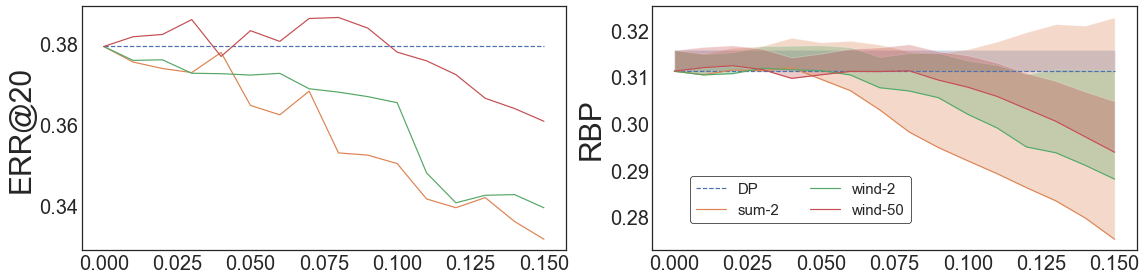

In [14]:
to = 15
fig3 = plot_single_orientation(['DP', 'sum-2', 'wind-2', 'wind-50'], RERANK_METRICS, 
                         [[base_res for x in range(len(sum_interp[:to+1]))], 
                          [x.mean() for x in sum_interp[:to+1]], 
                          [x.mean() for x in wind2_interp[:to+1]], 
                          [x.mean() for x in wind_interp[:to+1]]], 0.0, to/100, 0.01, styles=['--'], legend=True, legend_y=0.4, legend_x=0.8)

In [15]:
fig3.savefig('figures/para-interp.pdf')

In [33]:
interp_max = select_1d_max_stat_sig(['top-2-paras-rerank', 'para-rerank-window-50-context', 'para-rerank-window-2-context'], [sum_interp, wind_interp, wind2_interp], 0.0, 0.01, '$\mu$', base_qry, base_res, 1050, os.path.join(base_dir, 'dirichlet_prior', 'case-topics-{0}-dir-mu-300.00.run'), rerank_metrics).T

In [34]:
print(interp_max.drop(['Unjudged@20'], axis='columns').to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
     &   &       RR &   ERR@20 &     R@20 &     NDCG &      RBP \\
\midrule
base & $\mu$ &  1050.00 &  1050.00 &  1050.00 &  1050.00 &  1050.00 \\
     & - &   0.5686 &   0.3794 &   0.4600 &   0.4613 &   0.3113 \\
\bottomrule
\end{tabular}



In [35]:
from typing import List

def upperbound_runs(runs: List[pd.DataFrame]): 

    n = len(runs)

    cols = runs[0].columns
    query_maxes = []
    for c in cols:
        query_maxes.append({})

    for i in range(n):
        for row in runs[i].iterrows():
            for v, (metric, score) in enumerate(row[1].iteritems()):
                s = query_maxes[v].get(row[0], None)
                if s is None or s[1] < score:
                    query_maxes[v][row[0]] = (i, score, row[1]['unjudged@20'])
        
    return query_maxes


def make_upperbound(base_qry: pd.DataFrame, path: str):
    names = [x for x in ['gauss', 'inv', 'exp', 'wind']]
    names += ['sum', 'base']

    configs = ['case-topics-para-rerank-{0}-'.format(x)+str(y)+'-context-dir-mu-300.00.run' for x in ['gauss', 'inv', 'exp', 'window'] for y in [2, 5, 10, 20, 50, 100, 200, 300, 400]]   
    configs = [configs[i:i+9] for i in range(0, len(configs), 9)]
    configs += [['case-topics-top-{0}-paras-rerank-dir-mu-300.00.run'.format(x) for x in range(1, 11, 1)]]
    configs += [['case-topics-filtered-phrasestop-unigram_dir_mu_{0:.2f}.run'.format(x) for x in range(300, 3050, 50)]]
#     print(configs)
    
#     paths = []
    paths = [path]*(len(names)-1)
    paths.append(os.path.join(base_dir, 'preprocessing', 'dirichlet_prior'))

    ind = pd.MultiIndex.from_product([base_qry.columns, ['score', 'unjudged']])
    
    out_df_list = []

    for i, name in enumerate(names): 

        runs = load_dfs(config.AUS_QREL_PATH, config.AUS_REL_LEVEL, paths[i], configs[i], per_query=True)
        maxes = upperbound_runs(runs)

        all_m_dfs = []
        for j, x in enumerate(maxes):
            tmp = pd.DataFrame.from_dict(x).T
            sig = stats.ttest_rel(base_qry[base_qry.columns[j]].fillna(0).values, tmp[1].fillna(0).values).pvalue
            m = tmp.mean()
            if sig < 0.01:
                m.loc[1] = "{:.4f}".format(m.loc[1]) + "$^{**}$"
            elif sig < 0.05:
                m.loc[1] = "{:.4f}".format(m.loc[1]) + "$^{*}$"
            else: 
                m.loc[1] = '{0:.4f}'.format(m.loc[1])

            m.index=['lambda', 'score', 'unjudged']

            all_m_dfs.append((name, 'score', base_qry.columns[j], m['score']))
            all_m_dfs.append((name, 'unjudged', base_qry.columns[j], m['unjudged']))

        df = pd.DataFrame(all_m_dfs, index=ind)
        df.columns=['run', '', 'metric', name]
        out_df_list.append(df[name])
        
    return out_df_list

base_qry = load_1d_dfs(['filtered-phrasestop'], [config.AUS_QREL_PATH], os.path.join(base_dir, 'preprocessing', 'dirichlet_prior'), 'case-topics-{0}-unigram_dir_mu_{1:.2f}.run', rel_levels, 2400, 2400, 1, per_query=True)[0][0]
ub_no_interp = make_upperbound(base_qry, os.path.join(base_dir, 'dirichlet_prior'))

In [36]:
ub_metrics = copy.deepcopy(config.METRIC_NAMES)
del ub_metrics['recall_100']

df = pd.DataFrame(ub_no_interp)
# df.index = names
df = df.round(4)
df = df.T.loc[list(ub_metrics.keys())]
df = pd.DataFrame(df, index=pd.MultiIndex.from_product([['recip_rank', 'err@20', 'recall_20', 'ndcg', 'rbp@0.80'], ['score', 'unjudged']]))
df.index.set_levels(['-', 'unjudged'], level=1, inplace=True)
# df.index.set_levels(list(ub_metrics.values()), level=0, inplace=True)
# df 
print(df.T.to_latex(escape=False))

\begin{tabular}{lllllllllll}
\toprule
{} & \multicolumn{2}{l}{recip_rank} & \multicolumn{2}{l}{err@20} & \multicolumn{2}{l}{recall_20} & \multicolumn{2}{l}{ndcg} & \multicolumn{2}{l}{rbp@0.80} \\
{} &              - & unjudged &              - & unjudged &              - & unjudged &              - & unjudged &              - & unjudged \\
\midrule
gauss &  0.3913$^{**}$ &   7.4632 &  0.2275$^{**}$ &   6.9053 &  0.3019$^{**}$ &   6.7053 &  0.3474$^{**}$ &   7.2632 &  0.1643$^{**}$ &   7.3684 \\
inv   &  0.3382$^{**}$ &   6.5789 &  0.2072$^{**}$ &   6.4316 &  0.2562$^{**}$ &   6.4526 &  0.3349$^{**}$ &   6.3158 &  0.1505$^{**}$ &   6.3579 \\
exp   &  0.3421$^{**}$ &   6.7263 &  0.2005$^{**}$ &      6.6 &  0.2286$^{**}$ &   6.5579 &  0.3281$^{**}$ &   6.6316 &  0.1434$^{**}$ &   6.6105 \\
wind  &         0.4923 &   7.2421 &         0.2949 &   6.9895 &  0.3323$^{**}$ &   6.4842 &  0.3845$^{**}$ &   7.1263 &  0.1971$^{**}$ &   7.1368 \\
sum   &  0.4026$^{**}$ &   6.8105 &  0.2386$^{**}$ & 

In [37]:
#fig = plot_tune_1d_comp(['window-50-context', 'base'], rerank_metrics, [wind_interp, [base_res for x in range(len(wind_interp))]], 0.0, 1.0, 0.01)

In [38]:
def plot_paras(dfs, base_res, interpolation_val, metric_names, start, end, increment):
    
    iv = int(interpolation_val * 10) - 1
    r = int((len(metric_names)-1)/2)
    c = r
    fig, axs = plt.subplots(r, c, subplot_kw=dict(projection='3d'))
    fig.set_size_inches(16, 10)

    for d in dfs: 
        num_x = len(d[0][0])
        num_y = len(d[0])
        x = np.array([[i]*num_x for i in np.arange(1, 11, 1)])
        y = np.array([list(np.arange(start, end, increment))] * num_y)

        cnt = 0 
        row = 0
        for j in metric_names:
            axs[row, cnt].zaxis.set_rotate_label(False)
            axs[row, cnt].set_zlabel(metric_names[j], fontsize=20, rotation=90)

            z = np.array([[y[j]-res[0][i][j] for i, y in enumerate(x[iv])] for x in d])
            axs[row, cnt].plot_surface(x, y, z, cmap=cm.gray)
            
            cnt += 1 
            if cnt >= c: 
                cnt = 0 
                row += 1 
            
    fig.tight_layout()
    
    return fig 

para_tuning_fig = plot_paras([weight_dfs], base_res, 0.1, config.METRIC_NAMES, start, end, increment)

NameError: name 'res' is not defined

<Figure size 1152x720 with 9 Axes>

In [51]:
para_tuning_fig.savefig('pararerank-tune-para.pdf')

## Paragraph scoring

In [39]:
def load_para_dfs(qrel_path, results_path, run_format, rel_level, start, end, increment, per_query=False):
    dfs = []
    iterator =  np.arange(start, end, increment)
    weight_iterator = np.arange(0.1, 1.1, 0.1)

    for j in range(1, 11, 1):
        top_k_temp = []
        for l in iterator:
            top_k_temp.append(to_trec_df(os.path.join(QREL_BASE_DIR, QREL_DIRS[i], qrel_paths[i]), os.path.join(results_path, run_format.format(l, j)), rel_levels[i], per_query))
        dfs.append(top_k_temp)
    
    return dfs 

para_dfs = load_para_dfs(qrel_paths[0], os.path.join(BASE_DIR, PARA_DIR, 'dirichlet_prior'), 'unigram_dir_mu_{0:.2f}-topk-{1}.run', rel_levels[0], 300, 3050, 50)

NameError: name 'PARA_DIR' is not defined

In [14]:
def plot_3d_para(para_dfs, start, end, increment, metric_names):
    num_x = len(para_dfs[0])ausnl
    num_y = len(para_dfs)

    x = np.array([[i]*num_x for i in range(1, 11)])
    y = np.array([list(np.arange(start, end, increment))] * num_y)

    fig, axs = plt.subplots(2, int(len(metric_names)/2)+1, subplot_kw=dict(projection='3d'))
    fig.set_size_inches(16, 10)

    for j in metric_names:
        z = np.array([[l[j] for l in w] for w in para_dfs])
        axs[row, cnt].set_zlabel(metric_names[j],fontsize=20)

        axs[row, cnt].tick_params(labelsize=15)
        axs[row, cnt].yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        axs[row, cnt].plot_surface(x, y, z, cmap=cm.gray) 

        cnt+=1
        if cnt > 2: 
            cnt = 0 
            row+= 1

    fig.tight_layout()       
            
            
plot_3d_para(weight_dfs[0], 300, end, increment, metric_names)

NameError: name 'metric_names' is not defined

In [67]:
def plot_tune_1d(metric_names, df, start, end, increment): 
    fig, axs = plt.subplots(1, len(metric_names))
    fig.set_size_inches(16, 10)
    for j in range(len(metric_names)):
        y = [y[j] for y in df]
        axs[j].plot(np.arange(start, end, increment), y)
        axs[j].set_ylabel(metric_names[j],fontsize=20)

        if j == 1:
            axs[j].set_xlabel('$\mu$', fontsize=20)

        axs[j].tick_params(labelsize=15)
        axs[j].yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

    fig.tight_layout()

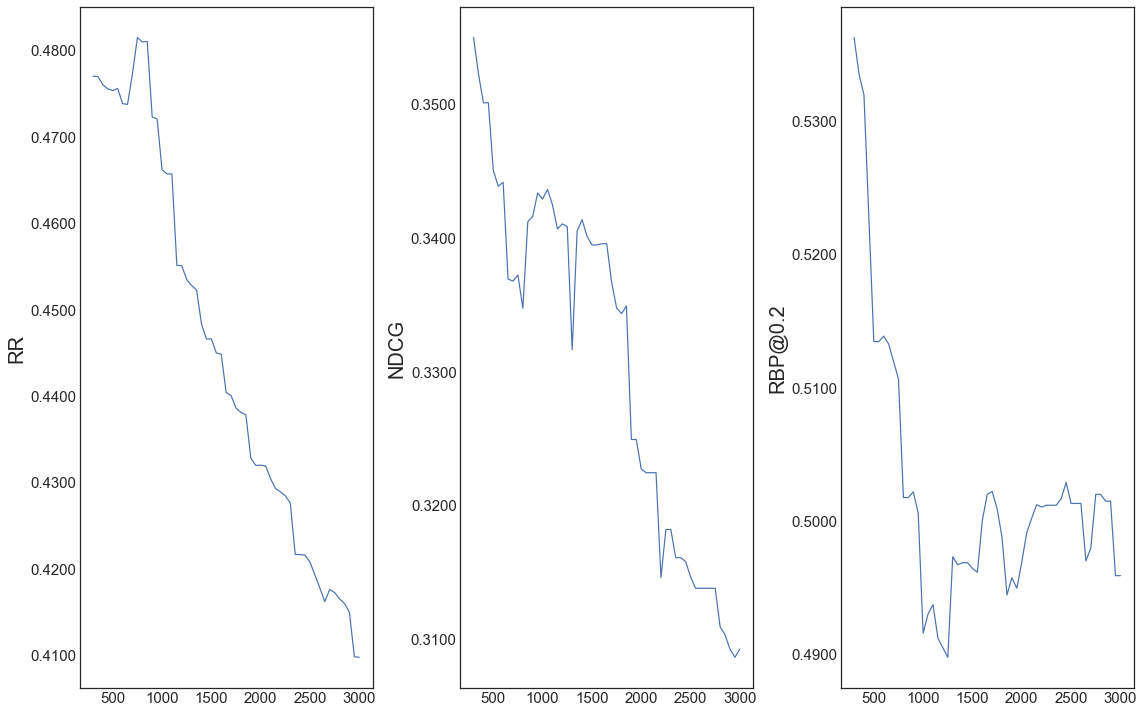

In [66]:
plot_tune_1d(['RR', 'NDCG', 'RBP@0.2'], para_dfs[-1], 300, 3050, 50)

In [36]:
# def load_1d(index_names, qrel_paths, results_path, run_format, rel_levels, start, end, increment, per_query=False):
#     dfs = []
#     iterator =  np.arange(start, end, increment)
#     for i, ind in enumerate(index_names):
#         temp = []
#         for l in iterator:
#             temp.append(to_trec_df(os.path.join(QREL_BASE_DIR, QREL_DIRS[i], qrel_paths[i]), os.path.join(results_path, run_format.format(ind, l)), rel_levels[i], per_query))
#         dfs.append(temp)
    
#     return dfs 


res = load_1d_dfs(['case-topics'], [config.AUS_QREL_PATH], os.path.join(base_dir, 'preprocessing', 'dirichlet_prior'), '{0}-filtered-phrasestop-unigram_dir_mu_{1:.2f}.run', rel_levels, 300, end, increment)[0][0]

In [64]:
## subtracted from baseline dirichlet prior run score 
def plot_tune_1d_subtract(metric_names, df, baseline, start, end, increment): 
    fig, axs = plt.subplots(2, int(len(metric_names)/2)+1)
    fig.set_size_inches(16, 10)
    cnt = 0
    x_val = np.arange(start, end, increment)
    row = 0 
    for j in metric_names:
        ys = [[y[j]-baseline for y in x] for x in df]
        for y in ys: 
            axs[row, cnt].plot(x_val, y)
        axs[row, cnt].set_ylabel(metric_names[j],fontsize=20)
#         axs[row, cnt].legend(range(1, 11, 1))

        axs[row, cnt].tick_params(labelsize=15)
        axs[row, cnt].yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        cnt+=1
        if cnt > 2: 
            cnt = 0 
            row+= 1

    fig.delaxes(axs[1, 2])
    fig.legend(range(1, 11, 1), bbox_to_anchor=[0.85, 0.46], frameon=True, ncol=2, prop={"size": 15}).get_frame().set_edgecolor('black')
    fig.tight_layout()

In [65]:
plot_tune_1d_subtract(config.METRIC_NAMES, weight_dfs[0], res[0], 300, 3050, 50)

<Figure size 1152x720 with 7 Axes>

In [47]:
print(len(weight_dfs))

1


In [100]:
run_res = []
for l in range(1, 10):
    r = TrecRun(os.path.join(BASE_DIR, PARA_DIR, 'dirichlet_prior', 'unigram_dir_mu_1000.00-topk-{0}.run'.format(l)))
    te = TrecEval(r, qrels[0])
    run_res.append((te.get_reciprocal_rank(per_query=True), te.get_ndcg(depth=100, per_query=True), te.get_rbp(0.6, depth=100, per_query=True)))


In [ ]:
metric_name_lookup = {
    'RR': 'recip_rank@1000',
    'NDCG': 'NDCG@100',
    'RBP@0.6': 'RBP(0.60)@100',
}

metric_order = {
    'RR': 0, 
    'NDCG': 1,
    'RBP@0.6': 2, 
}

def plot_per_query(metric_names, df, start, end, increment): 
    fig, axs = plt.subplots(1, len(metric_names))
    fig.set_size_inches(16, 10)
    for j in range(len(metric_names)):
        if j == 2:
#             print([y[j][0] for y in df])
            y = [y[j][0][metric_name_lookup[metric_names[j]]] for y in df]
        else: 
            y = [y[j][metric_name_lookup[metric_names[j]]] for y in df]
        axs[j].plot(np.arange(start, end, increment), y)
        axs[j].set_ylabel(metric_names[j],fontsize=20)

        if j+1 == len(metric_names):
            axs[j].set_xlabel('$\mu$', fontsize=20)

        axs[j].tick_params(labelsize=15)
        axs[j].yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

    fig.tight_layout()
    
plot_per_query(['RR', 'NDCG', 'RBP@0.6'], run_res, 1, 10, 1)

In [ ]:
def changed_queries(results, base, metric): 
    improved = set()
    for i, res in enumerate(results):
        order = metric_order[metric]
        name = metric_name_lookup[metric]
        if order == 2: 
            for k in res[order][0][name].index:
                if res[order][0][name][k] > base[order][0][name][k]:
                    improved.add(k)

        else: 
            for k in res[order][name].index:
                if res[order][name][k] > base[order][name][k]:
                    improved.add(k)

    return improved                
    
print(changed_queries(run_res, run_res[0], 'RBP@0.6'))

## Further comparison between window and sum 

I coulnd't be bothered making another table so just did stat sig and created table file manually.

In [1]:
top_2_res = load_1d_dfs(['top'], qrel_paths, os.path.join(base_dir, 'dirichlet_prior'), 'case-topics-top-2-paras-rerank-dir-mu-{1:.2f}.run', rel_levels, 300, 300, 1, per_query=True)[0][0]

NameError: name 'load_1d_dfs' is not defined

In [30]:
wind_2_res = load_1d_dfs(['top'], qrel_paths, os.path.join(base_dir, 'dirichlet_prior'), 'case-topics-para-rerank-window-2-context-dir-mu-{1:.2f}.run', rel_levels, 300, 300, 1, per_query=True)[0][0]


In [48]:
top_2_res[config.METRIC_NAMES].mean()

recip_rank     0.311954
err@20         0.185255
recall_20      0.227393
recall_100     0.721280
ndcg           0.323917
rbp@0.80       0.131127
unjudged@20    6.589474
dtype: float64

In [33]:
wind_2_res[config.METRIC_NAMES].mean()

recip_rank     0.302867
err@20         0.174375
recall_20      0.217009
recall_100     0.721280
ndcg           0.315441
rbp@0.80       0.124269
unjudged@20    6.673684
dtype: float64

In [37]:
from scipy import stats

In [38]:
for metric in config.METRIC_NAMES:
    print(metric, stats.ttest_rel(top_2_res[metric], wind_2_res[metric]))

recip_rank Ttest_relResult(statistic=0.7259337979903014, pvalue=0.4696829743875721)
err@20 Ttest_relResult(statistic=nan, pvalue=nan)
recall_20 Ttest_relResult(statistic=0.8474350142662814, pvalue=0.3989052395847109)
recall_100 Ttest_relResult(statistic=nan, pvalue=nan)
ndcg Ttest_relResult(statistic=1.7932360972258017, pvalue=0.07615120141937423)
rbp@0.80 Ttest_relResult(statistic=1.6425717909187139, pvalue=0.10381283714685695)
unjudged@20 Ttest_relResult(statistic=-1.0161753918744294, pvalue=0.3121542825386306)
